In [1]:
# Install necessary packages
!pip install gymnasium torch numpy matplotlib ambiance aerodynamics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd gdrive/MyDrive/rl/new_RLproject2

/content/gdrive/MyDrive/rl/new_RLproject2


In [4]:
!ls

 coordinate_of_the_system.jpg   rocket.py		       train_data2
 policy2.py		       'single_stage_rocket copy.py'   train.ipynb
 policy.py		        single_stage_rocket.py	       two_stage_rocket.py
 ppo_rocket.zip		        test_rocket.py		       two_stage_rocket_w_aerodynamics.py
 __pycache__		        test_train.py		       Untitled0.ipynb
 README.md		        train_data		       utils.py


In [5]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from ambiance import Atmosphere
import gymnasium as gym
from gymnasium import spaces
from rocket import Rocket  # Import Rocket class from rocket.py

In [6]:
from torch.distributions import Normal

In [7]:
Path = '/content/gdrive/MyDrive/rl/new_RLproject2/train_data/'

In [8]:
import pickle

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import os
import pickle
from collections import deque
import pandas as pd

class PPORocketAgent(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PPORocketAgent, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, state):
        return self.actor(state), self.critic(state)

    def get_action(self, state):
        action_mean, _ = self.forward(state)
        action_log_std = self.log_std.expand_as(action_mean)
        action_std = torch.exp(action_log_std)
        normal = Normal(action_mean, action_std)
        action = normal.sample()
        action_log_prob = normal.log_prob(action).sum(dim=-1)
        return action, action_log_prob

def scale_action(action, low, high):
    scaled_action = low + (0.5 * (action + 1.0) * (high - low))
    return scaled_action

def normalize_state(state):
    return (state - state.mean()) / (state.std() + 1e-8)

In [13]:
class PPORocketAgent(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PPORocketAgent, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, state):
        return self.actor(state), self.critic(state)

    def get_action(self, state):
        action_mean, _ = self.forward(state)
        action_log_std = self.log_std.expand_as(action_mean)
        action_std = torch.exp(action_log_std)
        normal = Normal(action_mean, action_std)
        action = normal.sample()
        action_log_prob = normal.log_prob(action).sum(dim=-1)
        return action, action_log_prob

def scale_action(action, low, high):
    scaled_action = low + (0.5 * (action + 1.0) * (high - low))
    return scaled_action

def normalize_state(state):
    return (state - state.mean()) / (state.std() + 1e-8)

def train_ppo_agent(env, agent, num_episodes=1000, learning_rate=1e-4, gamma=0.999, clip_epsilon=0.2, update_timestep=200, k_epochs=4, save_path='/content/gdrive/MyDrive/'):
    optimizer = optim.Adam(agent.parameters(), lr=learning_rate)
    mse_loss = nn.MSELoss()
    timestep = 0
    episode_rewards = []
    experience_buffer = deque(maxlen=update_timestep)
    action_records = []  # 액션 기록을 저장할 리스트

    action_low = np.array([-0.1] * 10 + [0] * 5 + [-0.1] * 6 + [0] * 3)
    action_high = np.array([0.1] * 10 + [env.max_thrust[0]] * 5 + [0.1] * 6 + [env.max_thrust[1]] * 3)

    # 모델 경로와 보상 경로 설정
    model_path = os.path.join(save_path, 'ppo_rocket_model.pth')
    rewards_path = os.path.join(save_path, 'episode_rewards.pkl')
    actions_path = os.path.join(save_path, 'action_records.csv')  # 액션 기록 경로

    # 모델 불러오기
    if os.path.exists(model_path):
        agent.load_state_dict(torch.load(model_path))
        print("Model loaded successfully!")

    # 에피소드 보상 불러오기
    if os.path.exists(rewards_path):
        with open(rewards_path, 'rb') as f:
            episode_rewards = pickle.load(f)
        print("Episode rewards loaded successfully!")

    for episode in range(num_episodes):
        state = env.reset()
        state = torch.FloatTensor(state).unsqueeze(0)
        episode_reward = 0
        epi_timestep = 0

        for t in range(env.max_step):
            epi_timestep += 1
            timestep += 1
            state = normalize_state(state)  # Normalize the state
            action, action_log_prob = agent.get_action(state)
            scaled_action = scale_action(action.detach().numpy()[0], action_low, action_high)
            next_state, reward, done, _ = env.step(scaled_action)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)

            episode_reward += reward
            advantage = reward + gamma * agent(next_state)[1].item() - agent(state)[1].item()
            advantage = torch.tensor(advantage).view(-1, 1).detach()  # Convert to tensor and detach

            # 경험을 버퍼에 추가
            experience_buffer.append((state, action, action_log_prob, advantage, reward, next_state))

            # 타임스텝마다 액션 기록
            if timestep % 10 == 0:
                action_records.append((episode, epi_timestep, action.detach().numpy()))

            # 버퍼가 업데이트 크기에 도달하면 업데이트 수행
            if len(experience_buffer) == update_timestep:
                for _ in range(k_epochs):
                    for state, action, action_log_prob, advantage, reward, next_state in experience_buffer:
                        state = normalize_state(state)  # Normalize the state
                        action_mean, state_value = agent(state)
                        action_log_std = agent.log_std.expand_as(action_mean)
                        action_std = torch.exp(action_log_std)
                        normal = Normal(action_mean, action_std)
                        log_prob = normal.log_prob(action).sum(dim=-1)
                        ratio = torch.exp(log_prob - action_log_prob.detach())
                        surr1 = ratio * advantage
                        surr2 = torch.clamp(ratio, 1-clip_epsilon, 1+clip_epsilon) * advantage
                        actor_loss = -torch.min(surr1, surr2).mean()
                        critic_loss = mse_loss(state_value, torch.tensor([reward + gamma * agent(next_state)[1].item()]).view(-1, 1).float().detach())
                        loss = 0.5 * critic_loss + actor_loss

                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # 업데이트 후 버퍼 비우기
                experience_buffer.clear()

            state = next_state

            if done:
                break

        episode_rewards.append(episode_reward)

        # 100개 에피소드마다 리워드 값을 플롯으로 업데이트
        if (episode + 1) % 100 == 0:
            plt.figure(figsize=(10, 5))
            plt.plot(episode_rewards[-100:])  # 최근 100개의 리워드를 플롯
            plt.xlabel('Episodes')
            plt.ylabel('Reward')
            plt.title('Reward of last 100 Episodes')
            plt.show()

        if episode % 100 == 0:
            print(f"Episode {episode}, Reward: {episode_reward}")
            env.show_path_from_state_buffer()
            # Save the model
            torch.save(agent.state_dict(), model_path)
            print(f"Model saved at {model_path}")
            # Save the episode rewards
            with open(rewards_path, 'wb') as f:
                pickle.dump(episode_rewards, f)
            print(f"Episode rewards saved at {rewards_path}")

    # 액션 기록을 CSV 파일로 저장
    actions_df = pd.DataFrame(action_records, columns=['Episode', 'Timestep', 'Action'])
    actions_df.to_csv(actions_path, index=False)
    print(f"Action records saved at {actions_path}")

    # Final save
    torch.save(agent.state_dict(), model_path)
    print(f"Final model saved at {model_path}")
    # Save the episode rewards
    with open(rewards_path, 'wb') as f:
        pickle.dump(episode_rewards, f)
    print(f"Final episode rewards saved at {rewards_path}")

    return episode_rewards

In [14]:
env = Rocket()
state_dim = env.state_dims
action_dim = env.action_dims
agent = PPORocketAgent(state_dim, action_dim)

# Train the agent
episode_rewards = train_ppo_agent(env, agent, num_episodes=10000, save_path=Path)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
episode_rewards

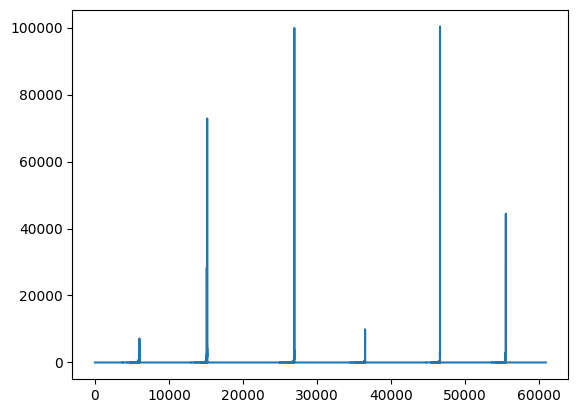

In [ ]:
plt.plot(episode_rewards)